# 0 - Import pakietów

In [ ]:
import string
import os
from abc import ABC, abstractmethod
import traceback
import io
from PIL import Image

import pandas as pd
import numpy as np

import joblib
from joblib import Parallel, delayed
from pandas import read_csv
from tqdm import tqdm

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer
import torch
import shap
from shap import maskers

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

---
# 1 - Pobranie danych

## 1.1 - Wczytanie pierwotnych danych

Dane umieszczone w lokalnych folderach projektu, a dokładniej w folderze `dane`.

In [2]:
train_df = pd.read_csv('data/train.csv', header=None, names=['opinion', 'title', 'content'])

In [3]:
test_df = pd.read_csv('data/test.csv', header=None, names=['opinion', 'title', 'content'])

Wyświetlenie pierwszych wierszy obu zbiorów danych:

In [4]:
train_df.head()

,opinion,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
test_df.head()

,opinion,title,content
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   opinion  int64 
 1   title    object
 2   content  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   opinion  400000 non-null  int64 
 1   title    399976 non-null  object
 2   content  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


Stworzenie listy zawierającej odniesienie do zbioru treningowego i testowego do działania na całości.

In [8]:
full_df = [train_df, test_df]

---
# 2 - Czyszczenie danych

Sprawdzenie, czy dane zwierają puste atrybyuty:

In [23]:
nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion      0
title      231
content      0
dtype: int64


Występują puste atrybuty w kolumnie *title*. W celu obsłużenia pustych danych, pozbywam się wszystkich kolumn, które takie dane zawierają oraz wyświetlam wynik:

In [24]:
for df in full_df:
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion    0
title      0
content    0
dtype: int64


---
# 3 - Przetwarzanie wstępne

## 3.1 - Przetworzenie tekstu do odpowiednich jednostek słownych

In [25]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
punctuation.update(["``", "''", "“", "”", "‘", "’", "«", "»", "„", "`", "´", "′", "″"])
punctuation_str = ''.join([p for p in punctuation if len(p) == 1])

Funkcja mająca na celu przetworzenie danych tekstowych, aby podzielić zbiory wyrazów na pojedyncze jednostki słowne do dalszej analizy. Co jest wykonywane:
- rozwinięcie kontrakcji na pełne wyrażenia;
- zamiana wszystkich liter na małe;
- tokenizacja;
- usuwanie znaków interpunkcyjnych;
- usuwanie słów mało znaczących w analizie takich jak spójniki i inne (zbiór *stopwords* w bibliotece NLTK);
- lematyzacja;
- stemming;

Gdzie na wyjście podawany jest do wyboru efekt tokenizacji, stemmingu lub lematyzacji.

In [26]:
def preprocess_text(text,
                    use_tokenization=False,
                    use_stemming=False,
                    use_lemmatization=False):
    """
    Parametry:
        - text                  : string, tekst do przetwarzania
        - use_stemming          : czy stosować stemming
        - use_lemmatization     : czy stosować lematyzację
        - use_tokenization      : czy zapisać efekt tokenizacji

    Wyjście:
        Słownik na wzór:
        {"stemmed": "very nice", "lemmatized": "very nice"}
    """

    # Rozwijnie kontrakcji ("I've -> I have" itp.)
    text = contractions.fix(text)

    # Zamiana na małe litery
    text = text.lower()

    # Tokenizacja
    tokens = word_tokenize(text)

    # Usunięcie znaków interpunkcyjnych
    filtered_tokens = [t.translate(str.maketrans('', '', punctuation_str)) for t in tokens]

    # Usunięcie stopwords (zbiór słów "pomijalnych" z NLTK)
    filtered_stopwords_tokens = []
    for t in filtered_tokens:
        if t in stop_words:
            continue
        filtered_stopwords_tokens.append(t)

    filtered_tokens = filtered_stopwords_tokens

    # Opcjonalny zapis do ramki wyjściowej efektów tokenizacji (samej), stemmingu lub lematyzacji
    output = {}
    if use_tokenization:
        output["tokenized"] = " ".join(tokens)

    if use_stemming:
        stemmed = [stemmer.stem(t) for t in filtered_tokens]
        output["stemmed"] = " ".join(stemmed)

    if use_lemmatization:
        lemmatized = [lemmatizer.lemmatize(t) for t in filtered_tokens]
        output["lemmatized"] = " ".join(lemmatized)

    return output

Funkcja przetwarzająca (równolegle) wskazane kolumny DataFrame, wywołując `preprocess_text` dla każdego wiersza w kolumnie.

In [27]:
def batch_preprocess_columns(
    df_og,
    columns_to_preprocess,  # np. ["title", "content"]
    suffixes=None,    # jaki dopisek do nazwy kolumny
    use_tokenization=False,
    use_stemming=False,
    use_lemmatization=False,
    n_jobs=-1,
    verbose=10
):
    """
    - df                    : wejściowy DataFrame
    - columns_to_preprocess : lista nazw kolumn do przetwarzania (np. ["title", "content"])
    - suffixes              : string - sufiks, np. "_processed", "_stemmed", itp. Zostanie dodany do nazwy.
    - use_tokenization, use_stemming, use_lemmatization:
        parametry przekazywane do `preprocess_text`
    - n_jobs                : ile równoległych zadań (jobów). -1 = użyj wszystkich rdzeni
    - verbose               : poziom szczegółowości logów joblib / tqdm

    Zwraca nowy DataFrame z dodatkowymi kolumnami <nazwa_kolumny> + <suffix>.
    """

    if suffixes is None:
        suffixes = {"tokenized": "_tokenized", "stemmed": "_stemmed", "lemmatized": "_lemmatized"}

    df = df_og.copy()
    result = pd.DataFrame()

    for col in columns_to_preprocess:
        texts = df[col].astype(str).tolist()

        # Przetwarzanie równoległe
        processed = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(preprocess_text)(
                text,
                use_stemming=use_stemming,
                use_lemmatization=use_lemmatization,
                use_tokenization=use_tokenization
            )
            for text in tqdm(texts, desc=f"Przetwarzanie kolumny {col}")
        )

        if use_tokenization:
            result[col + suffixes["tokenized"]] = [r.get("tokenized", "") for r in processed]

        if use_stemming:
            result[col + suffixes["stemmed"]] = [r.get("stemmed", "") for r in processed]

        if use_lemmatization:
            result[col + suffixes["lemmatized"]] = [r.get("lemmatized", "") for r in processed]

    return result

In [28]:
def process_or_read(train_file, test_file, train_df, test_df):
    if os.path.isfile(train_file):
        proc_train = read_csv(train_file, header=0)
    else:
        proc_train = batch_preprocess_columns(
            train_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
            verbose=0)

    if os.path.isfile(test_file):
        proc_test = read_csv(test_file, header=0)
    else:
        proc_test = batch_preprocess_columns(
            test_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
        )

    train_df = pd.concat([train_df, proc_train], axis=1)
    test_df = pd.concat([test_df, proc_test], axis=1)
    train_df['full_lematized'] = train_df['title_lemmatized'] + " " + train_df['content_lemmatized']
    test_df['full_lematized'] = test_df['title_lemmatized'] + " " + test_df['content_lemmatized']
    full_df = (train_df, test_df)
    return full_df

In [29]:
train_file = "train_opinions_processed_lemmatized.csv"
test_file = "test_opinions_processed_lemmatized.csv"

In [30]:
proc_train_df, proc_test_df = process_or_read(train_file, test_file, train_df, test_df)

In [31]:
proc_train_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even nongamer,sound track beautiful paint senery mind well ...,stuning even nongamer sound track beautiful p...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,best soundtrack ever anything,reading lot review saying best game soundtrack...,best soundtrack ever anything reading lot rev...
2,2,Amazing!,This soundtrack is my favorite music of all ti...,amazing,soundtrack favorite music time hand intense ...,amazing soundtrack favorite music time hand ...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack,truly like soundtrack enjoy video game music ...,excellent soundtrack truly like soundtrack enj...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull jaw floor hearing,played game know divine music every single s...,remember pull jaw floor hearing played game ...


In [32]:
proc_test_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,great cd,lovely pat one great voice generation listene...,great cd lovely pat one great voice generation...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,one best game music soundtrack game really play,despite fact played small portion game music ...,one best game music soundtrack game really pl...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,battery died within year,bought charger jul 2003 worked ok design nice...,battery died within year bought charger jul 2...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,work fine maha energy better,check maha energy website powerex mhc204f cha...,work fine maha energy better check maha energ...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,great nonaudiophile,reviewed quite bit combo player hesitant due u...,great nonaudiophile reviewed quite bit combo p...


## 3.2 - Ponowne sprawdzenie wartości pustych

In [33]:
print(proc_train_df.isna().sum())

opinion                   0
title                     0
content                   0
title_lemmatized      13055
content_lemmatized        1
full_lematized        13056
dtype: int64


Okazuję się, że po wstępnym przetworzeniu danych znajdują się komórki, w których usunięto całą zawartość. Jest to niewielki udział w stosunku do danych całościowych, ~13.000 do niemal 3.6 mln w zbiorze treningowym. Zakładam, że zaszło to także w zbiorze testowym, tam też usuwam wartości puste.

In [34]:
proc_train_df.dropna(inplace=True)
proc_test_df.dropna(inplace=True)
proc_train_df.reset_index(drop=True, inplace=True)
proc_test_df.reset_index(drop=True, inplace=True)

In [35]:
print(proc_train_df.isna().sum())
print(proc_test_df.isna().sum())

opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64
opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64


## 3.3 - Zapis do pliku

Zapis do pliku po pozbyciu się nieprawidłowych wartości.

In [36]:
columns_to_save = ["title_lemmatized", "content_lemmatized"]

In [37]:
if not os.path.isfile(train_file):
    proc_train_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)
if not os.path.isfile(test_file):
    proc_test_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)

---
# 4 - Analiza eksploracyjna

## 4.0 - Zestawienie koniecznych danych

In [38]:
positive_reviews = proc_train_df[proc_train_df['opinion'] == 2]['full_lematized']
negative_reviews = proc_train_df[proc_train_df['opinion'] == 1]['full_lematized']

positive_words_list = [word for review in positive_reviews for word in review.split()]
negative_words_list = [word for review in negative_reviews for word in review.split()]

## 4.1 - Analiza pojedynczych słów

Procentowy udział opinii pozytywnych i negatywnych

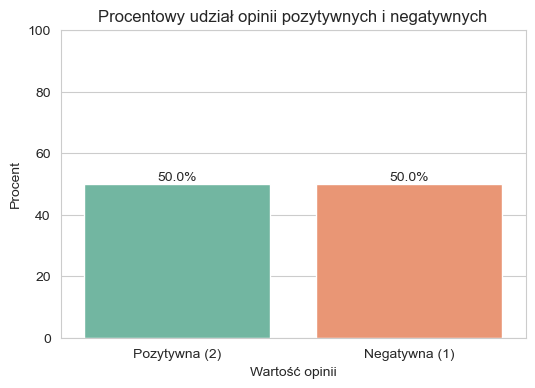

In [39]:
opinion_counts = train_df['opinion'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=opinion_counts.index, y=opinion_counts.values, palette='Set2', hue=opinion_counts.index, legend=False)

for i, percentage in enumerate(opinion_counts.values):
    ax.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)

plt.title('Procentowy udział opinii pozytywnych i negatywnych')
plt.xlabel('Wartość opinii')
plt.ylabel('Procent')
plt.xticks(ticks=[0, 1], labels=['Pozytywna (2)', 'Negatywna (1)'])
plt.ylim(0, 100)
plt.show()

Wykresy pokazujące ilość wystąpień poszczególnych słów w opiniach. Wykresy przedstawiają wystąpienia słów jedynie po tokenizacji oraz po pełnym przetwrzaniu z podziałem na sentyment.

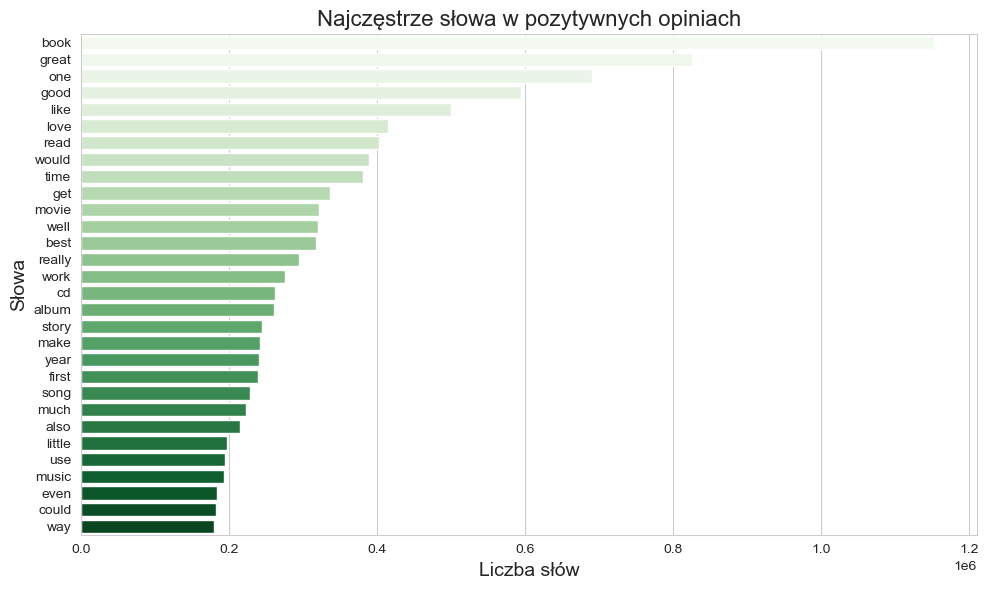

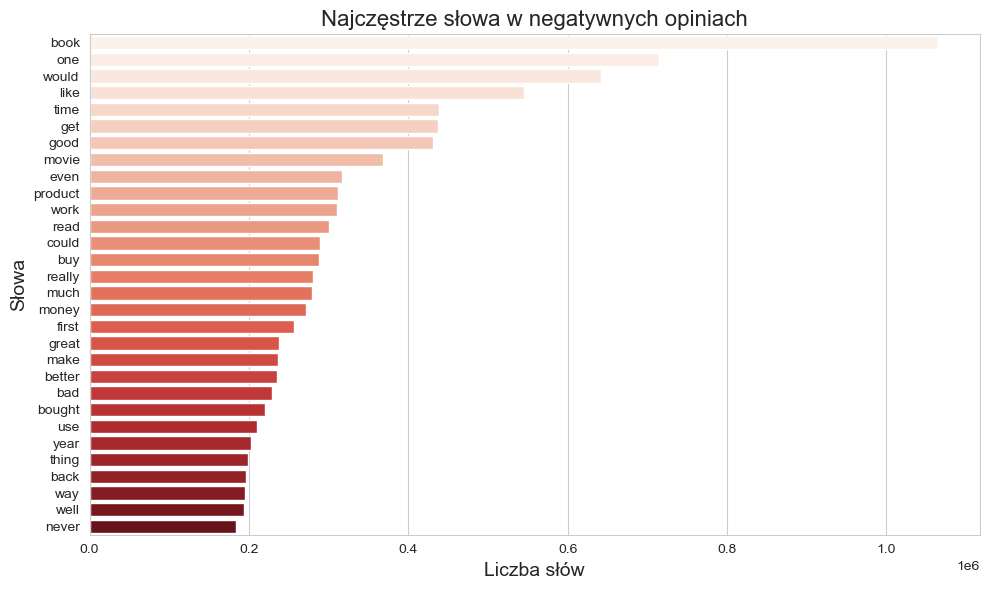

In [40]:
# Najczęstsze słowa dla pozytywnych i negatywnych recenzji

positive_words_counter = Counter(positive_words_list).most_common(30)
negative_words_counter = Counter(negative_words_list).most_common(30)

def plot_most_common_words(common_words, sentiment, color):
    words, counts = zip(*common_words)  # Rozpakowanie słów i ich zliczeń
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette=color, hue=list(words), legend=False)
    plt.title(f'Najczęstrze słowa w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Liczba słów', fontsize=14)
    plt.ylabel('Słowa', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_most_common_words(positive_words_counter, 'pozytywnych', 'Greens')
plot_most_common_words(negative_words_counter, 'negatywnych', 'Reds')

## 4.2 - Analiza *n*-gramów

In [41]:
def get_ngrams(corpus, ngram_range=(2,2)):
    vec = CountVectorizer(
        ngram_range=ngram_range,
        min_df=5,
        max_features=1000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq

In [42]:
def plot_ngrams(ngrams, sentiment, color, ngram='n', n=30):
    ngrams = ngrams[:n]
    combinations_, counts = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=combinations_, palette=color, hue=counts, legend=False)
    plt.title(f'Najczęstrze {ngram}-gramy w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Częstotliwość', fontsize=14)
    plt.ylabel(f'{ngram}-gramy', fontsize=14)
    plt.tight_layout()
    plt.show()

In [43]:
two_grams_positive = get_ngrams(positive_reviews, ngram_range=(2,2))

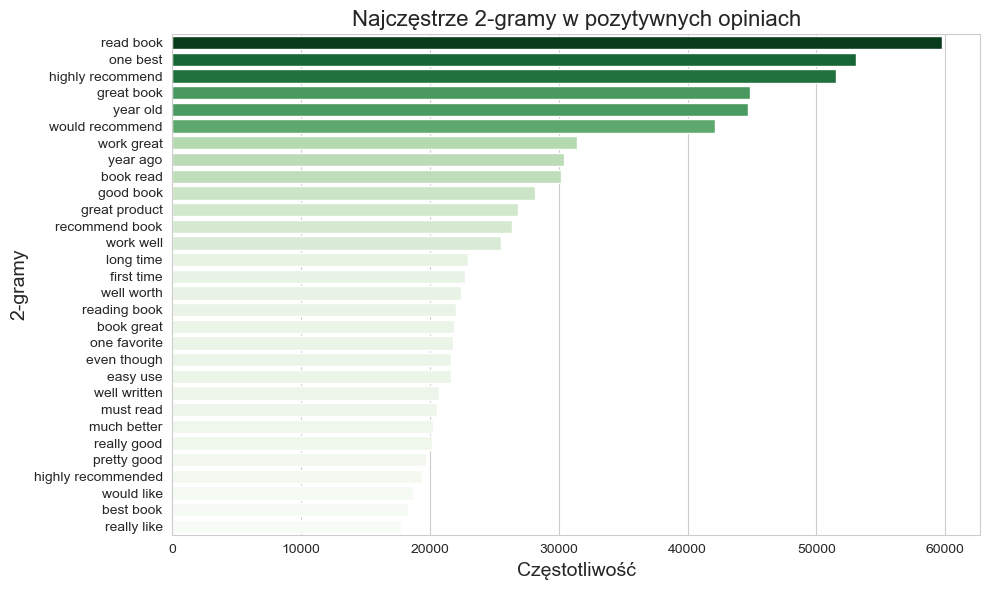

In [44]:
plot_ngrams(two_grams_positive, 'pozytywnych', 'Greens', ngram='2')

In [45]:
two_grams_negative = get_ngrams(negative_reviews, ngram_range=(2,2))

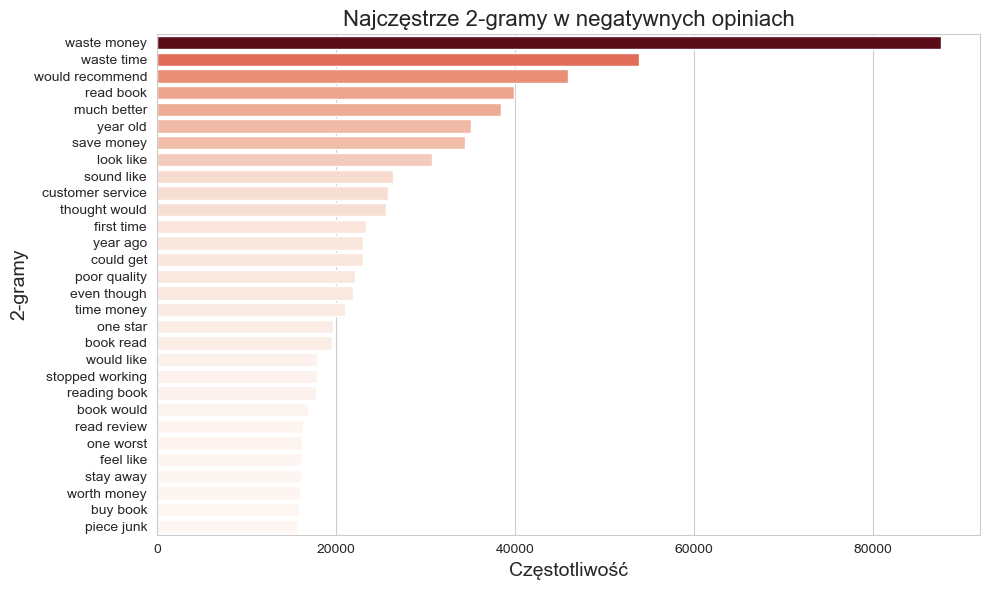

In [46]:
plot_ngrams(two_grams_negative, 'negatywnych', 'Reds', ngram='2')

In [47]:
three_grams_positive = get_ngrams(positive_reviews, ngram_range=(3,3))

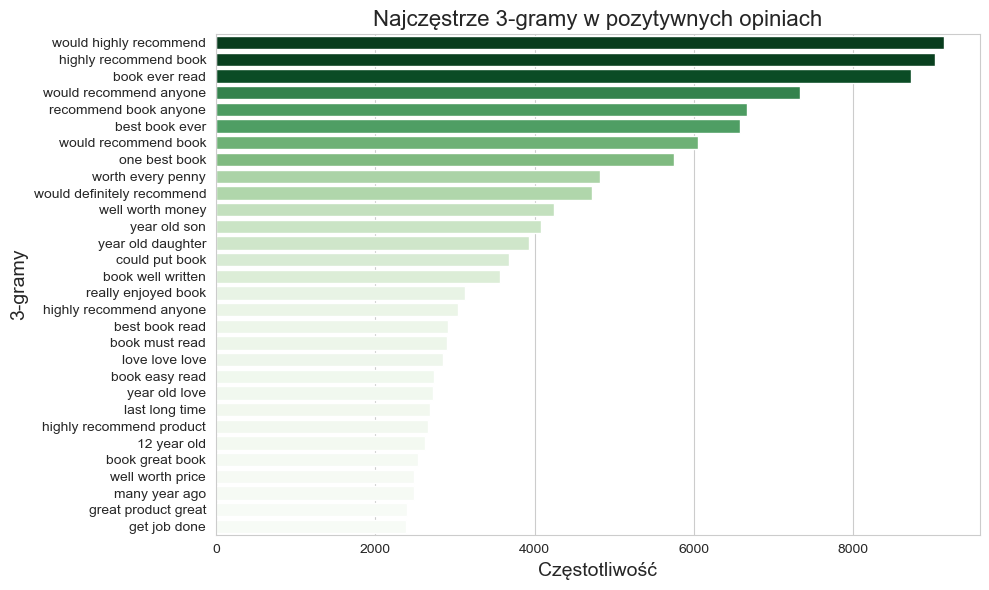

In [48]:
plot_ngrams(three_grams_positive, 'pozytywnych', 'Greens', ngram='3')

In [49]:
three_grams_negative = get_ngrams(negative_reviews, ngram_range=(3,3))

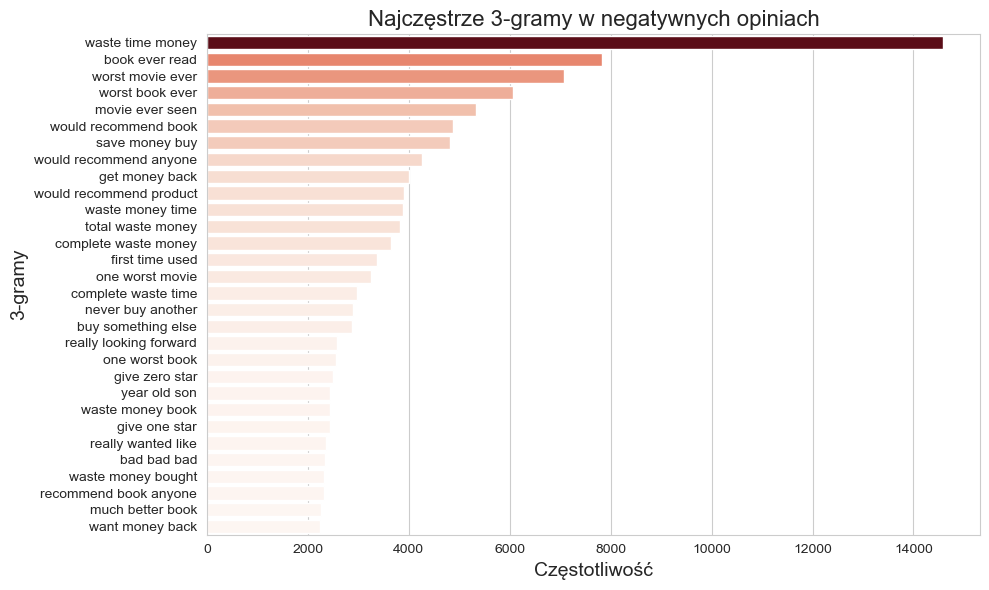

In [50]:
plot_ngrams(three_grams_negative, 'negatywnych', 'Reds', ngram='3')

---
# 5 - TF-IDF

Wybranie optymalnych parametrów dla *TF-IDF*.

Wybranie 10% zbioru danych treninigowych do wybrania parametrów *TF-IDF*

In [ ]:
X_sample, X_rest, y_sample, y_rest = train_test_split(
    proc_train_df['full_lematized'],
    proc_train_df['opinion'],
    train_size=0.1,
    random_state=42,
    stratify=proc_train_df['opinion']  # klucz do uzyskania reprezentatywnej próbki
)

Sprawdzenie skuteczności różnych wartości parametrów *TF-IDF* przy użyciu prostego klasyfikatora regresji logistycznej.

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=200))
])

param_grid = {
    'tfidf__max_features': [500, 1_000, 2_000, 4_000, 8_000, 12_000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_sample, y_sample)

results = pd.DataFrame(grid.cv_results_)

# Tabela przestawna
pivot_table = results.pivot(
    index='param_tfidf__max_features',
    columns='param_tfidf__ngram_range',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f"
)

plt.xlabel("ngram_range")
plt.ylabel("max_features")
plt.title("Wyniki grid search")
plt.gca().invert_yaxis()
plt.show()

# 6 - Klasyfikatory pakietu sci-kit-learn

## 6.0 - Utworzenie koniecznych danych

Przypisanie nowych nazw na elementy zbioru treningowego i testowego.

In [26]:
X_train, X_test, y_train, y_test = proc_train_df['full_lematized'], proc_test_df['full_lematized'], proc_train_df['opinion'], proc_test_df['opinion']

Utworzenie gotowych macierzy *tf-idf*, aby posiadać numeryczne wejścia odpowiadające oryginalnym danym. Jest to potrzebne do trenowania i walidacji klasyfikatorów.

In [25]:
best_tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2)
)

In [27]:
X_train_tfidf = best_tfidf.fit_transform(X_train)

In [28]:
X_test_tfidf = best_tfidf.transform(X_test)

## 6.1 - Funkcje do przetwarzania klasyfikatorów sci-kit-learn

In [76]:
def plot_cv_results_heatmap(
    cv_results_df,
    param_x,
    param_y,
    score_col='mean_test_score',
    xlabel='Param X',
    ylabel='Param Y',
    title='Wyniki grid search',
    invert_yaxis=False,
    cmap='viridis'
    ):

    pivot_table = cv_results_df.pivot(
        index=param_y,
        columns=param_x,
        values=score_col
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap=cmap)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if invert_yaxis:
        plt.gca().invert_yaxis()

    plt.show()

In [79]:
class skl_classifier:

    def __init__(self, model):
        self.model = model
        self.y_pred = None
        self.grid = None
        self.params = None
        self.main_save_dir = 'classifiers_results'
        self.specific_save_dir = None

    def fit(self, X_train, y_train, save_classifier=True):
        self.model.fit(X_train, y_train)
        if True:
            os.makedirs(self.specific_save_dir, exist_ok=True)
            file_name = os.path.join(self.specific_save_dir, "classifier.joblib")
            joblib.dump(self.model, file_name)
            print(f"Klasyfikator scikit-learn zapisany w: {file_name}")

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)

    def fit_predict(self, X_train, y_train, X_test, save_classifier=True):
        if hasattr(self.model, 'fit_predict') and callable(getattr(self.model, 'fit_predict')):
            self.y_pred = self.model.fit_predict(X_test)
            if True:
                os.makedirs(self.specific_save_dir, exist_ok=True)
                file_name = os.path.join(self.specific_save_dir, "classifier.joblib")
                joblib.dump(self.model, file_name)
                print(f"Klasyfikator scikit-learn zapisany w: {file_name}")
        else:
            self.fit(X_train, y_train)
            self.y_pred = self.model.predict(X_test)

    def tune_evaluation(self, params_to_heatmap=None):
        cv_results = pd.DataFrame(self.grid.cv_results_)
        print(cv_results)

        if params_to_heatmap:
            for param_pair in params_to_heatmap:
                param_pair[0] = f"param_{self.params[param_pair[0]]}"
                param_pair[1] = f"param_{self.params[param_pair[1]]}"
                plot_cv_results_heatmap(
                    cv_results_df = cv_results,
                    param_x       = param_pair[0],   # np. 'param_clf__C'
                    param_y       = param_pair[1],   # np. 'param_clf__penalty'
                    score_col     = 'mean_test_score',
                    xlabel        = param_pair[0].split("__")[-1], # np. 'C'
                    ylabel        = param_pair[1].split("__")[-1], # np. 'penalty'
                    invert_yaxis=True,
                    cmap='Blues'
                )

    def tune(self, X_train, y_train, pipeline, param_grid, tune_split_percentage=0.1, cv=3, n_jobs=-1, save_results=True, params_to_heatmap=None):
        X_sample, _, y_sample, _ = train_test_split(
            X_train, y_train,
            train_size=tune_split_percentage,
            random_state=42,
            stratify=y_train
        )

        self.grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=cv,   # cross-validation
            scoring='accuracy',
            n_jobs=n_jobs,
            refit=False
        )

        self.params = list(self.grid.param_grid.keys())
        self.specific_save_dir = os.path.join(self.main_save_dir, self.model.__class__.__name__, "-".join([param.split("__")[-1] for param in self.params]))

        self.grid.fit(X_sample, y_sample)

        best_params = self.grid.best_params_
        model_params_to_set = {}
        prefix = 'clf__' # Założenie, że krok klasyfikatora w pipeline nazywa się 'clf'
        for param_name, value in best_params.items():
            if param_name.startswith(prefix):
                model_params_to_set[param_name.split(prefix, 1)[1]] = value

        self.model.set_params(**model_params_to_set)

        if save_results:
            os.makedirs(self.specific_save_dir, exist_ok=True)
            file_name = os.path.join(self.specific_save_dir, "tuning_grid.joblib")
            joblib.dump(self.grid, file_name)
            print(f"Obiekt GridSearchCV został zapisany do pliku: {file_name}")

        self.tune_evaluation(params_to_heatmap)

    def evaluate(self, y_test, labels=None, save_predictions=True):
        if labels is None:
            labels = self.model.classes_

        cm = confusion_matrix(y_test, self.y_pred, labels=labels)
        report = classification_report(y_test, self.y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm,
            annot=True,
            fmt="d",
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
        plt.title("Macierz pomyłek")
        plt.xlabel("Przewidziane wartości")
        plt.ylabel("Wartości prawdziwe")
        plt.show()

        print("Classification Report:")
        print(report)

        if save_predictions:
            os.makedirs(self.specific_save_dir, exist_ok=True)
            file_name = os.path.join(self.specific_save_dir, "predicted_labels.csv")
            df_predictions = pd.DataFrame(self.y_pred)
            df_predictions.to_csv(file_name)
            print(f"Zapisano wyniki predykcji w: {file_name}")

    def load_from_directory(self, directory_path=None, grid_file=None, model_file=None, pred_file=None):
        if os.path.isdir(directory_path):
            if grid_file:
                self.grid = joblib.load(os.path.join(directory_path, grid_file))
            if model_file:
                self.model = joblib.load(os.path.join(directory_path, model_file))
            if pred_file:
                self.model = joblib.load(os.path.join(directory_path, pred_file))

## 6.2 - Badanie klasyfikatorów

### 6.2.1 - Regresja logistyczna

Obiekt GridSearchCV został zapisany do pliku: classifiers_results\LogisticRegression\C-penalty-solver\tuning_grid.joblib
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       85.161259      1.368623        12.746737        0.476059   
1       84.287616      1.555421        13.370255        0.630625   
2      111.626311      1.723515        12.751016        0.177179   
3       89.760533      2.952761        13.382548        0.329913   
4       84.550032      1.706825        12.993054        0.455337   
5      103.232136      5.594913        11.989902        0.551985   
6      215.286877     24.587710         5.992309        0.176921   
7       73.198463      0.702023        11.870660        0.075467   
8       98.014666      0.671551        11.914310        0.115441   
9      350.483846      4.489118         5.456793        0.095820   
10      70.194241      5.918621        10.524776        1.891492   
11      70.388669      3.191909         7.083495        0.46378

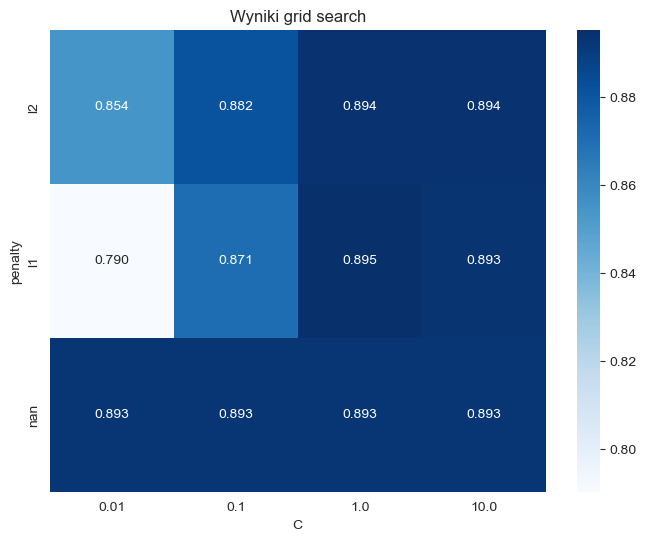

classifiers_results\LogisticRegression\C-penalty-solver\classifier.joblib
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA`
Klasyfikator scikit-learn zapisany w: classifiers_results\LogisticRegression\C-penalty-solver\classifier.joblib


In [82]:
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['saga']
}
model = LogisticRegression(n_jobs=-1)
pipeline = Pipeline([
        ('tfidf', best_tfidf),
        ('clf', model)
    ])
params_to_heatmap = [[0, 1]]
logi_reg = skl_classifier(model)
logi_reg.tune(X_train, y_train, pipeline, param_grid, params_to_heatmap=params_to_heatmap)
logi_reg.fit_predict(X_train_tfidf[:1000000], y_train[:1000000], X_test_tfidf[:100000])

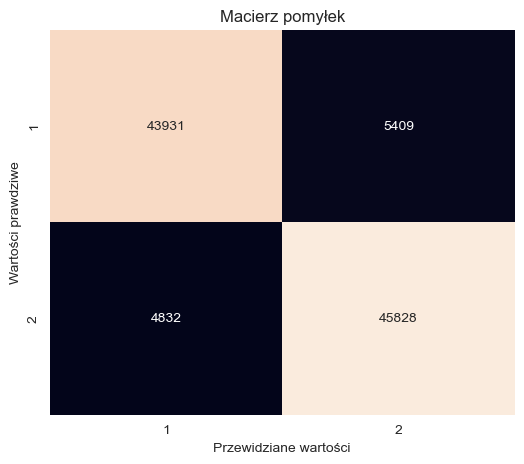

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.89      0.90     49340
           2       0.89      0.90      0.90     50660

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000

Zapisano wyniki predykcji w: classifiers_results\LogisticRegression\C-penalty-solver\predicted_labels.csv


In [83]:
logi_reg.evaluate(y_test[:100000], labels=[1, 2])

### 6.2.2 - Drzewo decyzyjne

In [ ]:
param_grid_dt = {
    'clf__max_depth': [2, 5, 20, 40, 80, 120],
    'clf__criterion': ['gini', 'entropy']
}
tune_and_evaluate_model(DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test, param_grid_dt, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf)

### 6.2.3 - Las losowy

In [ ]:
param_grid_rf = {
    'clf__max_depth': [2, 5, 20, 40, 80, 120],
    'clf__criterion': ['gini', 'entropy']
}
tune_and_evaluate_model(RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_test, y_test, param_grid_rf, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf)

# 7 - Modele Hugging Face

## 7.1 - Funkcje

In [104]:
def check_device():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        if torch.cuda.is_available():
            print(f"Device name: {torch.cuda.get_device_name(0)}")
        return device

def subset_data(train_df, test_df, train_split_percentage, test_split_percentage):

    train_subset_df, _ = train_test_split(
        train_df[['content', 'opinion']],
        train_size=train_split_percentage,
        random_state=42,
        stratify=train_df['opinion']
    )

    test_subset_df, _ = train_test_split(
        test_df[['content', 'opinion']],
        train_size=test_split_percentage,
        random_state=42,
        stratify=test_df['opinion']
    )

    return train_subset_df, test_subset_df

In [119]:
class hf_model:
    def __init__(self, model_name, content_column, label_column, num_labels, label_map=None, model_output_dir=None, model_logging_dir=None, model_max_length=128):
        self.device = check_device()
        self.model_name = model_name
        self.content_column = content_column
        self.label_column = label_column
        self.label_map = label_map
        self.num_labels = num_labels
        self.model_max_length = model_max_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=model_max_length, padding="max_length", truncation=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(self.device)
        self.trainer = None
        self.eval_results = None

        if model_output_dir is None:
            self.model_output_dir = f'./results_{model_name.replace("/", "_")}'
        else:
            self.model_output_dir = model_output_dir
        if model_logging_dir is None:
            self.model_logging_dir = f'./logs_{model_name.replace("/", "_")}'
        else:
            self.model_logging_dir = model_logging_dir

    def _df_to_dataset(self, df):
        df = df.astype({'content': 'string', 'label': 'int64'})
        return Dataset.from_pandas(df[['content', 'label']])

    def _preprocess_df(self, df: pd.DataFrame) -> pd.DataFrame:
        processed_df = df.copy() # Pracuj na kopii, aby nie modyfikować oryginalnego DataFrame poza klasą

        if self.label_map:
            processed_df[self.label_column] = processed_df[self.label_column].map(self.label_map)

            # Usuwanie wierszy, gdzie mapowanie się nie powiodło
            processed_df.dropna(subset=[self.label_column], inplace=True)
            processed_df[self.label_column] = processed_df[self.label_column].astype(int)

        # Zmiana nazwy oryginalnej kolumny etykiet na 'label', jeśli jest inna
        if self.label_column != 'label':
            processed_df.rename(columns={self.label_column: 'label'}, inplace=True)

        if self.label_column != 'content':
            processed_df.rename(columns={self.content_column: 'content'}, inplace=True)

        processed_df['label'] = processed_df['label'].astype('int64')
        processed_df['content'] = processed_df['content'].astype('string')

        return processed_df

    @staticmethod
    def _compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary') # 'binary' dla klasyfikacji binarnej
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def load_from_checkpoint(self, checkpoint_dir: str):
        print(f"Wczytywanie modelu i tokenizera z checkpointa: {checkpoint_dir}...")
        try:
            # Wczytanie konfiguracji z checkpointa, aby być pewnym np. co do num_labels
            config = AutoConfig.from_pretrained(checkpoint_dir)
            if hasattr(config, 'num_labels') and self.num_labels != config.num_labels:
                print(f"Aktualizacja num_labels z {self.num_labels} na {config.num_labels} na podstawie konfiguracji checkpointa.")
                self.num_labels = config.num_labels

            # Użycie model_max_length z obiektu, chyba że config tokenizera z checkpointu mówi inaczej.
            self.tokenizer = AutoTokenizer.from_pretrained(
                checkpoint_dir,
                model_max_length=self.model_max_length # Można zachować spójność
            )

            self.model = AutoModelForSequenceClassification.from_pretrained(
                checkpoint_dir
                # num_labels jest odczytywane z config.json wewnątrz checkpoint_dir
            ).to(self.device)

            # Aktualizowanie model_name, aby odzwierciedlał źródło wczytanego modelu
            self.model_name = checkpoint_dir
            print(f"Model i tokenizer pomyślnie wczytane z checkpointa: {checkpoint_dir}")

        except Exception as e:
            print(f"Błąd podczas wczytywania modelu lub tokenizera z checkpointa {checkpoint_dir}: {e}")

    def show_results(self):
        if self.eval_results is None:
            print("Brak wyników ewaluacji do pokazania.")
            return

        print(f"\n--- Wyniki ewaluacji modelu {self.model_name.capitalize()} (na zbiorze testowym) ---")
        results_df = pd.DataFrame([self.eval_results])

        # Wybieranie i zmiana nazw kluczowych metryk dla przejrzystości
        metrics_to_show = {
            'eval_loss': 'Loss',
            'eval_accuracy': 'Accuracy',
            'eval_f1': 'F1 Score',
            'eval_precision': 'Precision',
            'eval_recall': 'Recall',
            'eval_runtime': 'Runtime (s)',
            'eval_samples_per_second': 'Samples/sec',
        }

        # Filtrowanie kolumn i zmiana ich nazw
        results_df_filtered = results_df[[col for col in metrics_to_show if col in results_df.columns]]
        results_df_filtered = results_df_filtered.rename(columns=metrics_to_show)

        print(results_df_filtered.to_markdown()) # Wyświetl jako tabelę markdown

    @staticmethod
    def _tokenize_function(examples, tokenizer):
        return tokenizer(examples["content"])

    def _tokenize(self, dataset):
        # Tokenizowanie zbiorów danych zgodnie z tokenizatorem dla modelu
        try:
            # Przekazanie funkcji bezpośrednio, a tokenizer przez fn_kwargs
            tokenized_dataset = dataset.map(
                self._tokenize_function,
                batched=True,
                fn_kwargs={'tokenizer': self.tokenizer}
            )
            return tokenized_dataset
        except Exception as e:
            print(e)

    def train(self, training_args, train_df, eval_df=None): # Dodany eval_df
        processed_train_df = self._preprocess_df(train_df)
        hf_train_dataset = self._df_to_dataset(processed_train_df)

        print("Tokenizowanie danych treningowych...")
        tokenized_train_dataset = self._tokenize(hf_train_dataset)

        tokenized_eval_dataset = None
        # Przetwarzanie eval_df tylko jeśli został dostarczony i strategia ewaluacji tego wymaga
        if eval_df is not None and training_args.eval_strategy != "no":
            processed_eval_df = self._preprocess_df(eval_df)
            hf_eval_dataset = self._df_to_dataset(processed_eval_df)
            tokenized_eval_dataset = self._tokenize(hf_eval_dataset)

        training_args.output_dir = self.model_output_dir
        training_args.logging_dir = self.model_logging_dir

        # Trainer
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self._compute_metrics,
            processing_class=self.tokenizer,
            train_dataset=tokenized_train_dataset,
            eval_dataset=tokenized_eval_dataset
        )

        # Trenowanie na zbiorze treningowym
        print("Rozpoczęcie treningu...")
        try:
            self.trainer.train()
        except Exception as e:
            print(e)

    def evaluate(self, eval_df, per_device_eval_batch_size=64):
        """
        Przeprowadza ewaluację na podanym zbiorze danych.
        Jeśli model został wczytany z checkpointa i nie przechodził treningu w tej sesji,
        tworzy tymczasowy obiekt Trainer do przeprowadzenia ewaluacji.
        """
        # Jeśli trainer nie istnieje (bo np. tylko wczytaliśmy model)
        if self.trainer is None:
            print("Trainer nie istnieje. Tworzenie tymczasowego Trainera do ewaluacji...")

            # Minimalnej konfiguracji TrainingArguments
            temp_training_args = TrainingArguments(
                output_dir=f"./temp_eval_{self.model_name.replace('/', '_').replace('.', '_')}",
                per_device_eval_batch_size=per_device_eval_batch_size,
                report_to="none"  # Wyłącz logowanie do zewnętrznych serwisów (np. W&B)
            )

            # Obiekt Trainer z wczytanym modelem i tokenizerem
            self.trainer = Trainer(
                model=self.model,
                args=temp_training_args,
                tokenizer=self.tokenizer,
                compute_metrics=self._compute_metrics
            )
        processed_eval_df = self._preprocess_df(eval_df)
        hf_eval_dataset = self._df_to_dataset(processed_eval_df)

        print("Tokenizowanie danych testowych...")
        tokenized_test_dataset = self._tokenize(hf_eval_dataset)

        print("Rozpoczęcie ewaluacji modelu...")
        try:
            self.eval_results = self.trainer.evaluate(eval_dataset=tokenized_test_dataset)
        except Exception as e:
            print(e)

        self.show_results()

    def train_evaluate(self, training_args, train_df, eval_df):
        self.train(training_args, train_df, eval_df)
        self.evaluate(eval_df)

In [106]:
def calculate_shap_values(
    hf_model_list,
    text_samples_df: pd.DataFrame,
):
    """
    Funkcja oblicza wartości SHAP dla listy modeli i zwraca je w słowniku.
    """
    shap_results = {}

    for hf_model_obj in hf_model_list:
        print(f"--- Przetwarzanie modelu: {hf_model_obj.model_name} ---")
        model = hf_model_obj.model
        tokenizer = hf_model_obj.tokenizer
        device = hf_model_obj.device
        content_column = hf_model_obj.content_column
        model_max_length = hf_model_obj.model_max_length
        num_labels = hf_model_obj.num_labels

        texts_to_explain = text_samples_df[content_column].astype(str).tolist()

        def predictor(batch_of_masked_sentences_np_array):
            masked_sentences_list = batch_of_masked_sentences_np_array.tolist()
            inputs = tokenizer(
                masked_sentences_list,
                padding="max_length",
                truncation=True,
                max_length=model_max_length,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                logits = model(**inputs).logits
            probabilities = torch.softmax(logits, dim=-1)
            return probabilities.cpu().numpy()

        text_masker = shap.maskers.Text(tokenizer=tokenizer)

        explainer = shap.Explainer(
            predictor,
            text_masker,
            output_names=[f"Klasa {i}" for i in range(num_labels)]
        )

        print(f"Obliczanie wartości SHAP dla {len(texts_to_explain)} próbek...")
        try:
            shap_values = explainer(texts_to_explain)
        except Exception as e:
            print(f"Błąd podczas obliczania wartości SHAP dla modelu {hf_model_obj.model_name}: {e}")
            traceback.print_exc()
            continue # Przejdź do następnego modelu w razie błędu

        # Zapisujemy cały obiekt shap_values dla danego modelu
        shap_results[hf_model_obj.model_name] = shap_values
        print(f"Obliczenia SHAP dla modelu {hf_model_obj.model_name} zakończone.")

    return shap_results

In [107]:
def create_plot_as_image(plot_function, shap_values_slice, base_value=None, feature_names=None, **kwargs):
    """
    Tworzy pojedynczy wykres SHAP w pamięci i zwraca go jako obiekt obrazu PIL.
    """
    buf = io.BytesIO()
    fig = plt.figure(figsize=(10, 8), dpi=150)

    if plot_function == shap.plots.decision:
        plot_function(base_value, shap_values_slice.values, feature_names=feature_names, show=False, **kwargs)
    else: # Dla 'bar' i innych
        plot_function(shap_values_slice, show=False, **kwargs)

    plt.tight_layout(pad=1.0)
    fig.savefig(buf, format='png')
    plt.close(fig)

    buf.seek(0)
    image = Image.open(buf)
    return image

In [108]:
def plot_shap_grid(
    shap_results: dict,
    plot_types: list,
    num_samples_to_plot: int,
    target_class_idx: int,
):
    """
    Generuje każdy wykres jako osobny obrazek, a następnie układa je w siatce.
    """
    matplotlib_plot_types = [pt for pt in plot_types if pt in ['bar', 'waterfall', 'decision']]
    if not matplotlib_plot_types:
        return

    model_names = list(shap_results.keys())
    num_models = len(model_names)

    num_rows = 0
    plot_tasks = []

    if 'bar' in matplotlib_plot_types:
        num_rows += 1
        plot_tasks.append({'type': 'bar'})

    if 'waterfall' in matplotlib_plot_types:
        num_rows += num_samples_to_plot
        for i in range(num_samples_to_plot):
            plot_tasks.append({'type': 'waterfall', 'sample_idx': i})

    if 'decision' in matplotlib_plot_types:
        num_rows += num_samples_to_plot
        for i in range(num_samples_to_plot):
            plot_tasks.append({'type': 'decision', 'sample_idx': i})

    if num_rows == 0:
        return

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_models, figsize=(10 * num_models, 8 * num_rows), squeeze=False)

    for j, model_name in enumerate(model_names):
        shap_values = shap_results[model_name]

        for i, task in enumerate(plot_tasks):
            ax = axs[i, j]
            image = None
            title = ""

            if task['type'] == 'bar':
                plot_name = task['type'].capitalize()
                title = f"{plot_name} plot\n{model_name}"
                image = create_plot_as_image(shap.plots.bar, shap_values[:, :, target_class_idx])

            elif task['type'] in ['waterfall', 'decision']:
                sample_idx = task['sample_idx']
                plot_name = task['type'].capitalize()

                title = f"{plot_name} plot - Próbka {sample_idx+1}\n{model_name}"

                # Dane SHAP tylko dla jednej, konkretnej próbki
                single_sample_shap = shap_values[sample_idx, :, target_class_idx]

                image = create_plot_as_image(
                    plot_function=getattr(shap.plots, task['type']),
                    shap_values_slice=single_sample_shap,
                    base_value=single_sample_shap.base_values,
                    feature_names=list(single_sample_shap.data)
                )

            ax.set_title(title)
            if image:
                ax.imshow(image)

    plt.show()

## 7.2 - Porównywanie modeli

### 7.2.0 - Potrzebne rzeczy

In [109]:
sub_train_df, sub_test_df = subset_data(train_df=train_df, test_df=test_df, train_split_percentage=0.25, test_split_percentage=0.25)

In [110]:
content_column = "content"
label_column = "opinion"
num_labels = 2
label_map = {1: 0, 2: 1}

### 7.2.1 - Distilbert/Base/Uncased

In [120]:
distilbert = hf_model("distilbert-base-uncased", content_column, label_column, num_labels, label_map=label_map)

Using device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
                num_train_epochs=1,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                warmup_steps=100,
                weight_decay=0.01,
                logging_steps=100,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                report_to="none",
                fp16=True
            )
distilbert.train_evaluate(training_args, sub_train_df, sub_test_df)

In [121]:
checkpoint_path = './results_distilbert-base-uncased/checkpoint-112494'
distilbert.load_from_checkpoint(checkpoint_dir=checkpoint_path)

Wczytywanie modelu i tokenizera z checkpointa: ./results_distilbert-base-uncased/checkpoint-112494...
Model i tokenizer pomyślnie wczytane z checkpointa: ./results_distilbert-base-uncased/checkpoint-112494


### 7.2.2 - Bert/Base/Uncased

In [122]:
bert_base = hf_model("bert-base-uncased", content_column, label_column, num_labels, label_map=label_map)

Using device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
                num_train_epochs=1,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                warmup_steps=100,
                weight_decay=0.01,
                logging_steps=100,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                report_to="none",
                fp16=True
            )
bert_base.train_evaluate(training_args, sub_train_df, sub_test_df)

In [123]:
checkpoint_path = './results_bert-base-uncased/checkpoint-112494'
bert_base.load_from_checkpoint(checkpoint_dir=checkpoint_path)

Wczytywanie modelu i tokenizera z checkpointa: ./results_bert-base-uncased/checkpoint-112494...
Model i tokenizer pomyślnie wczytane z checkpointa: ./results_bert-base-uncased/checkpoint-112494


### 7.2.3 - Roberta/Base

In [124]:
roberta_base = hf_model("roberta-base", content_column, label_column, num_labels, label_map=label_map)

Using device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=42,
    per_device_eval_batch_size=42,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    group_by_length=True,
    gradient_checkpointing=True,
    fp16=True
)
roberta_base.train_evaluate(training_args, sub_train_df, sub_test_df)

In [125]:
checkpoint_path = './results_roberta-base/checkpoint-21429'
roberta_base.load_from_checkpoint(checkpoint_dir=checkpoint_path)

Wczytywanie modelu i tokenizera z checkpointa: ./results_roberta-base/checkpoint-21429...
Model i tokenizer pomyślnie wczytane z checkpointa: ./results_roberta-base/checkpoint-21429


## 7.3 - Wyniki modeli

### 7.3.1 - Wyniki liczbowe

In [126]:
hf_model_list=[distilbert, bert_base, roberta_base]
for hf_model in hf_model_list:
    hf_model.evaluate(sub_test_df)

Trainer nie istnieje. Tworzenie tymczasowego Trainera do ewaluacji...


C:\Users\bordo\AppData\Local\Temp\ipykernel_13184\554876424.py:185: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(


Tokenizowanie danych testowych...


Map: 100%|██████████| 100000/100000 [00:06<00:00, 15821.56 examples/s]


Rozpoczęcie ewaluacji modelu...



--- Wyniki ewaluacji modelu ./results_distilbert-base-uncased/checkpoint-112494 (na zbiorze testowym) ---
|    |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|---:|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
|  0 | 0.180922 |    0.95033 |   0.950058 |    0.955293 |  0.94488 |       136.783 |       731.087 |
Trainer nie istnieje. Tworzenie tymczasowego Trainera do ewaluacji...
Tokenizowanie danych testowych...


C:\Users\bordo\AppData\Local\Temp\ipykernel_13184\554876424.py:185: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(
Map: 100%|██████████| 100000/100000 [00:09<00:00, 10287.49 examples/s]


Rozpoczęcie ewaluacji modelu...



--- Wyniki ewaluacji modelu ./results_bert-base-uncased/checkpoint-112494 (na zbiorze testowym) ---
|    |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|---:|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
|  0 | 0.238526 |     0.9391 |   0.939145 |    0.938451 |  0.93984 |       267.771 |       373.453 |
Trainer nie istnieje. Tworzenie tymczasowego Trainera do ewaluacji...


C:\Users\bordo\AppData\Local\Temp\ipykernel_13184\554876424.py:185: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(


Tokenizowanie danych testowych...


Map: 100%|██████████| 100000/100000 [00:07<00:00, 12890.95 examples/s]


Rozpoczęcie ewaluacji modelu...



--- Wyniki ewaluacji modelu ./results_roberta-base/checkpoint-21429 (na zbiorze testowym) ---
|    |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|---:|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
|  0 | 0.109411 |     0.9636 |   0.963566 |    0.964473 |  0.96266 |       257.712 |        388.03 |


### 7.3.2 - Sposób działania modeli na wykresach SHAP

--- Przetwarzanie modelu: ./results_distilbert-base-uncased/checkpoint-112494 ---
Obliczanie wartości SHAP dla 20 próbek...


PartitionExplainer explainer: 21it [00:17,  1.91s/it]                        


Obliczenia SHAP dla modelu ./results_distilbert-base-uncased/checkpoint-112494 zakończone.
--- Przetwarzanie modelu: ./results_bert-base-uncased/checkpoint-112494 ---
Obliczanie wartości SHAP dla 20 próbek...


PartitionExplainer explainer: 21it [00:30,  2.37s/it]                        


Obliczenia SHAP dla modelu ./results_bert-base-uncased/checkpoint-112494 zakończone.
--- Przetwarzanie modelu: ./results_roberta-base/checkpoint-21429 ---
Obliczanie wartości SHAP dla 20 próbek...


PartitionExplainer explainer: 21it [00:34,  2.43s/it]                        


Obliczenia SHAP dla modelu ./results_roberta-base/checkpoint-21429 zakończone.


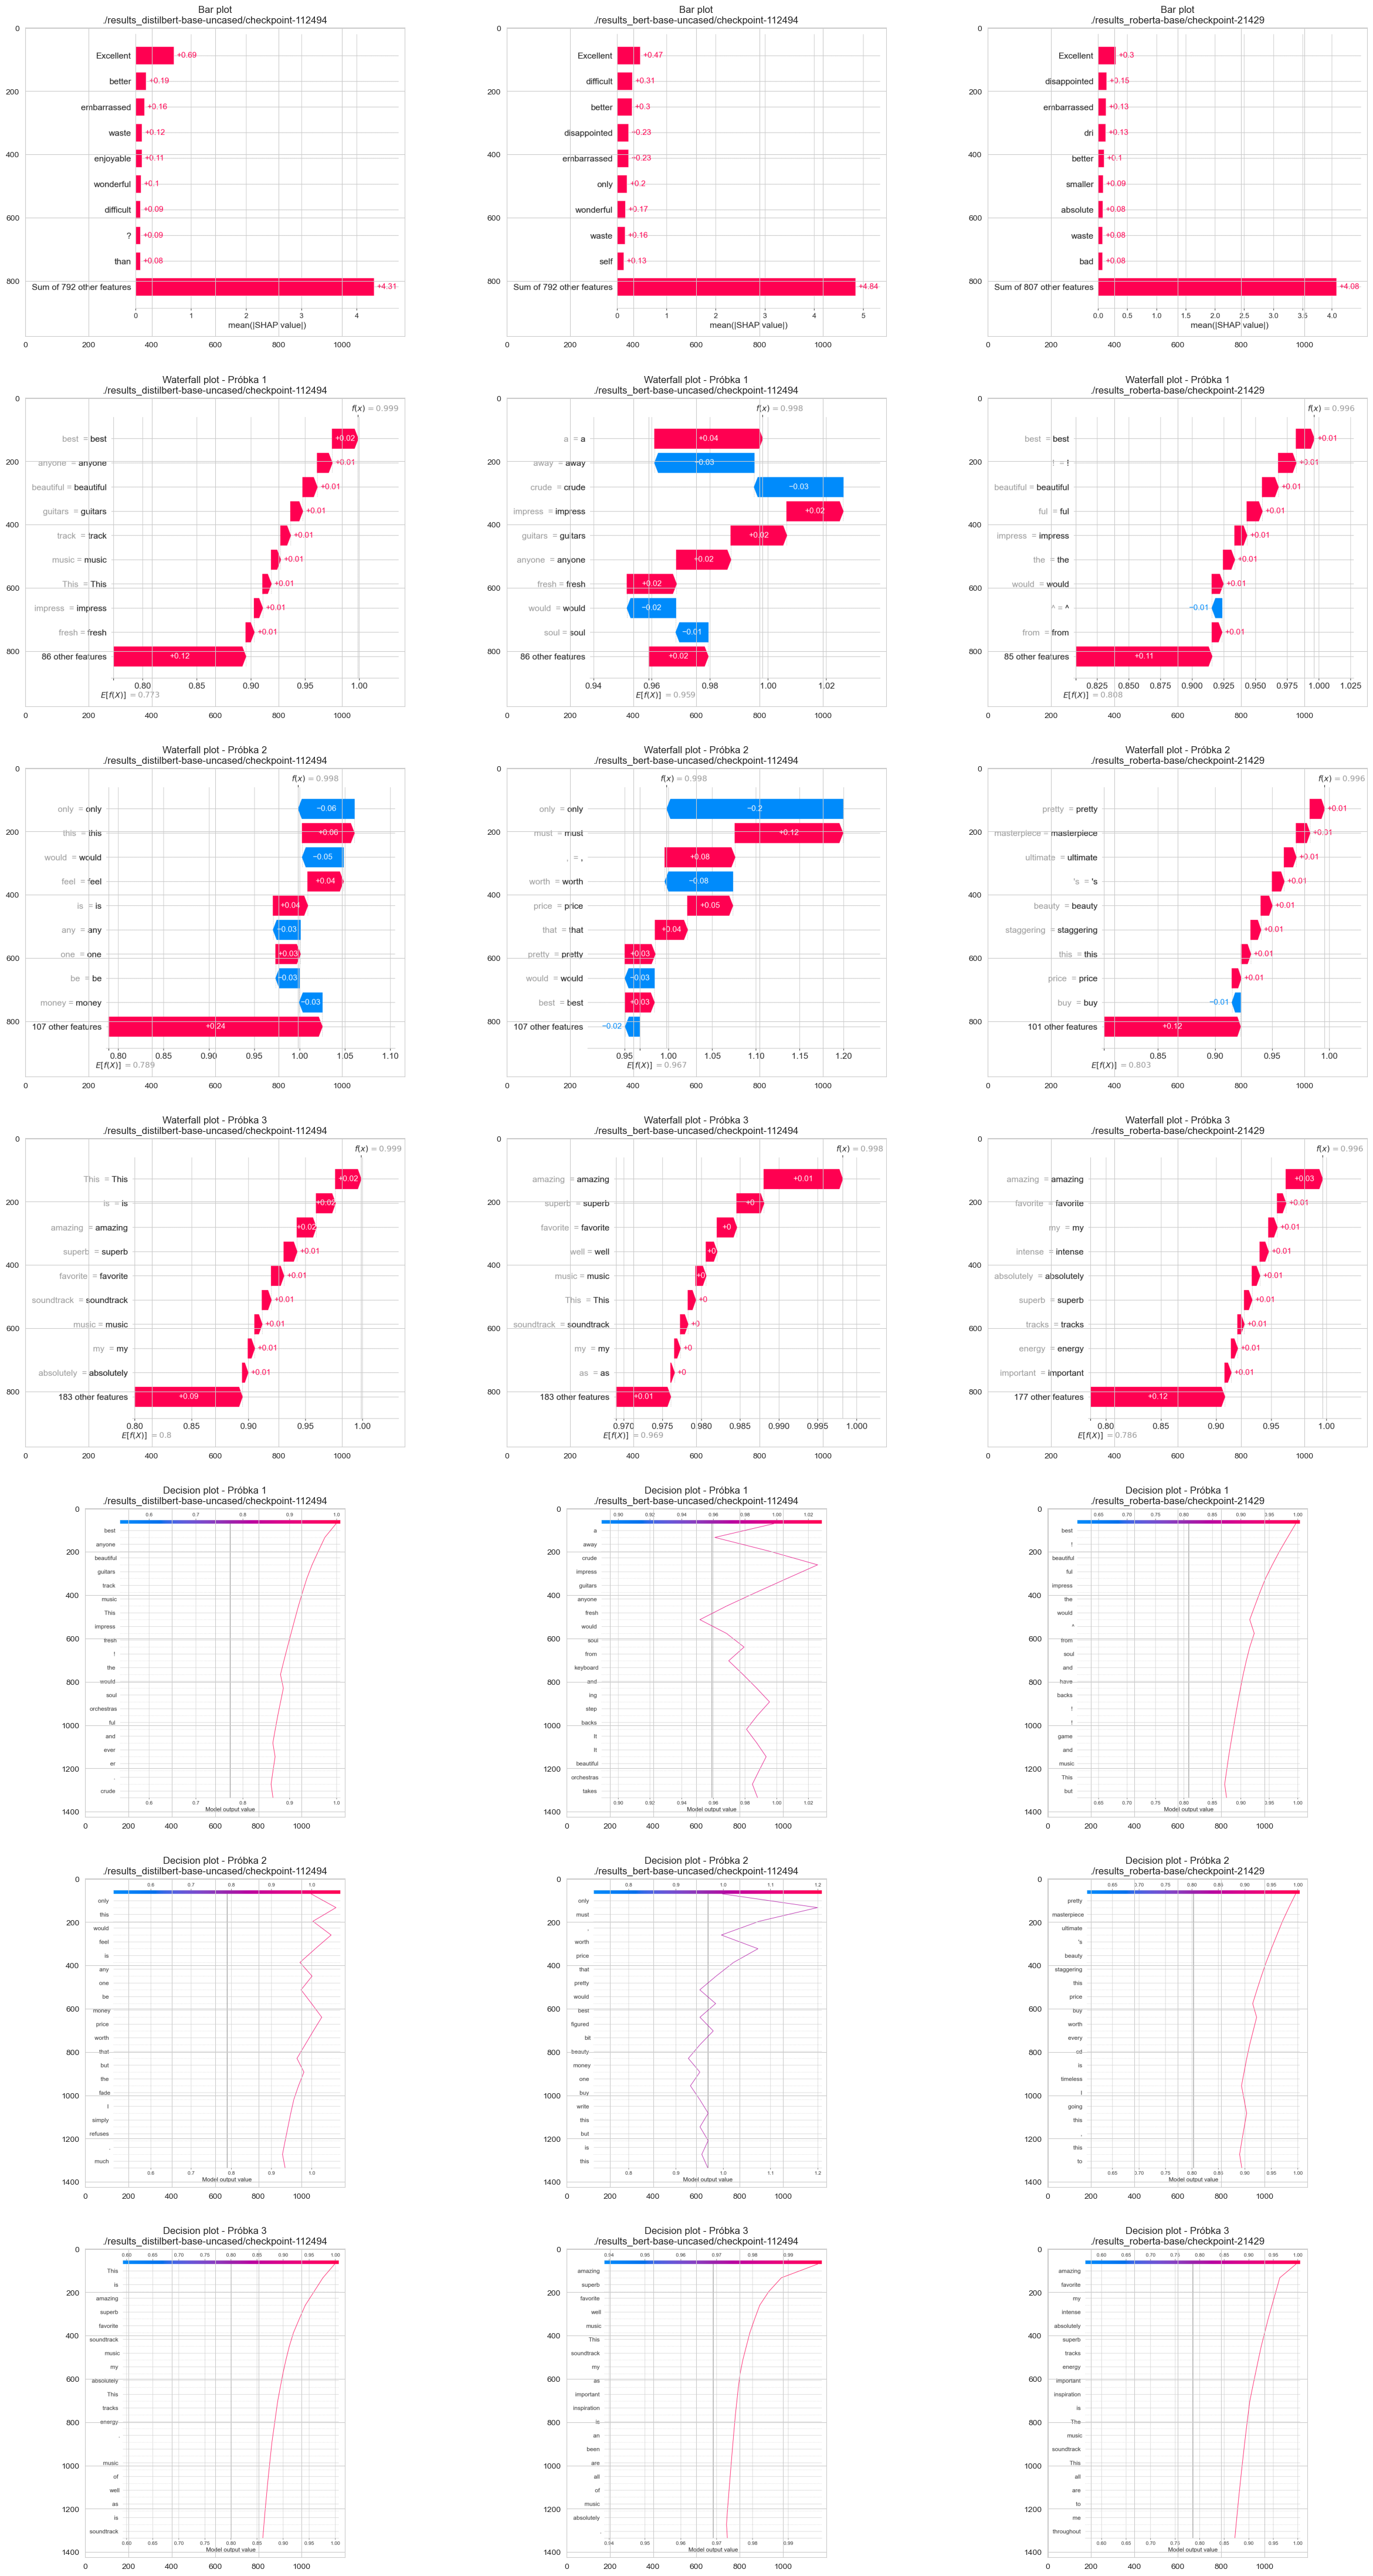

In [127]:
# Wartości SHAP dla wszystkich modeli
shap_data = calculate_shap_values(
    hf_model_list=[distilbert, bert_base, roberta_base],
    text_samples_df=train_df[:20]
)

# Siatka z wynikami dla wybranych typów wykresów
plot_shap_grid(
    shap_results=shap_data,
    plot_types=['bar', 'waterfall', 'decision'],
    num_samples_to_plot=3,
    target_class_idx=1,
)